<a href="https://colab.research.google.com/github/meltyyyyy/kaggle-amex/blob/main/Notebooks/LGBM/Average.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
class Config:
    name = "LGBM/Average"

    n_splits = 5
    seed = 2022
    target = "target"

    # Colab Env
    upload_from_colab = True
    api_path = "/content/drive/MyDrive/workspace/kaggle.json"
    drive_path = "/content/drive/MyDrive/workspace/kaggle-amex"
    
    # Kaggle Env
    kaggle_dataset_path = None

    # Github Env
    need_push = True

In [ ]:
import os
import json
import warnings
import shutil
import logging
import joblib
import random
import datetime
import sys
import gc
import multiprocessing
import joblib
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
tqdm.pandas()
warnings.filterwarnings('ignore')

In [ ]:
COLAB = "google.colab" in sys.modules
if COLAB:
    print("This environment is Google Colab")
    
    # mount
    from google.colab import drive
    if not os.path.isdir("/content/drive"):
        drive.mount('/content/drive') 
	
    # import library
    # ! pip install lightgbm==3.3.1
    # ! pip install --quiet iterative-stratification
    # ! pip install --quiet tensorflow-addons

    # use kaggle api (need kaggle token)
    f = open(Config.api_path, 'r')
    json_data = json.load(f) 
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]
    
    # set dirs
    DRIVE = Config.drive_path
    EXP = (Config.name if Config.name is not None 
           else get("http://172.28.0.2:9000/api/sessions").json()[0]["name"][:-6])
    NOTEBOOKS = os.path.join(DRIVE, 'Notebooks')
    INPUT = os.path.join(DRIVE, "Input")
    OUTPUT = os.path.join(DRIVE, "Output")
    SUBMISSION = os.path.join(DRIVE, "Submission")
    OUTPUT_EXP = os.path.join(OUTPUT, EXP) 
    EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
    EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
    EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

    # make dirs
    for d in [INPUT, SUBMISSION, EXP_MODEL, EXP_FIG, EXP_PREDS]:
        os.makedirs(d, exist_ok=True)

    # if not os.path.isfile(os.path.join(INPUT, "amex-default-prediction.zip")):
        # load dataset
        # ! kaggle competitions download -c amex-default-prediction -p $INPUT

else:
    print("This environment is Kaggle Kernel")
    
    # set dirs
    INPUT = "../input/amex-default-prediction"
    EXP, OUTPUT, SUBMISSION = "./", "./", "./"
    EXP_MODEL = os.path.join(EXP, "model")
    EXP_FIG = os.path.join(EXP, "fig")
    EXP_PREDS = os.path.join(EXP, "preds")
    
    # copy dirs
    if Config.kaggle_dataset_path is not None:
        KD_MODEL = os.path.join(Config.kaggle_dataset_path, "model")
        KD_EXP_PREDS = os.path.join(Config.kaggle_dataset_path, "preds")
        shutil.copytree(KD_MODEL, EXP_MODEL)
        shutil.copytree(KD_EXP_PREDS, EXP_PREDS)

    # make dirs
    for d in [EXP_MODEL, EXP_FIG, EXP_PREDS]:
        os.makedirs(d, exist_ok=True)

This environment is Google Colab
Mounted at /content/drive


In [ ]:
with open(os.path.join(INPUT, 'data_types.json'), "r") as rf:
    dtypes = json.load(rf)
train = pd.read_parquet(os.path.join(INPUT, 'train.parquet') if COLAB else 'train.parquet')
train = train.astype(dtypes)
target = pd.read_csv(os.path.join(INPUT, 'train_labels.csv') if COLAB else 'train_labels.csv', dtype={'customer_ID': 'str', 'target': 'int8'})
# train = pd.read_parquet(os.path.join(INPUT, 'train_small.parquet') if COLAB else 'train_small.parquet')
test = pd.read_parquet(os.path.join(INPUT, 'test.parquet') if COLAB else 'test.parquet')
test = test.astype(dtypes)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5531451 entries, 0 to 5531450
Columns: 190 entries, customer_ID to D_145
dtypes: category(2), datetime64[ns](1), float16(185), int8(1), object(1)
memory usage: 2.0+ GB


In [ ]:
train.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827


## Evaluation merics

In [ ]:
# https://www.kaggle.com/code/inversion/amex-competition-metric-python

def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

def lgb_amex_metric(y_true, y_pred):
    """The competition metric with lightgbm's calling convention"""
    return ('amex',
            amex_metric(pd.DataFrame({'target': y_true}), pd.Series(y_pred, name='prediction')),
            True)

## Preprocess

Take mean for some features.

In [ ]:
# avg features come from https://www.kaggle.com/code/ambrosm/amex-lightgbm-quickstart/notebook
def add_avg_features(df):
  avg_features = ['B_1', 'B_11', 'B_16', 'B_17', 'B_18', 'B_2', 'B_20',
                'B_28', 'B_3', 'B_4', 'B_5', 'B_7', 'B_9', 'D_112',
                'D_121', 'D_141', 'D_39', 'D_41', 'D_42', 'D_43',
                'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 
                'D_50', 'D_51', 'D_53', 'D_54', 'D_56', 'D_58', 
                'D_59', 'D_60', 'D_91', 'P_2', 'P_3', 'R_1', 'R_2', 
                'R_27', 'R_3', 'R_7', 'S_11', 'S_26', 'S_3', 'S_5']
  # Disable tqdm since it slows down speed
  # avg_df = df[['customer_ID'] + avg_features].groupby('customer_ID')\
  #   .progress_apply(np.mean, axis=0)\
  #   .rename(columns={f: f"{f}_avg" for f in avg_features})\
  #   .reset_index(drop=False)
  avg_df = df[['customer_ID'] + avg_features].groupby('customer_ID')\
    .mean()\
    .rename(columns={f: f"{f}_avg" for f in avg_features})\
    .reset_index(drop=False)
  df = df.drop(avg_features, axis=1).merge(avg_df, on='customer_ID', how='left')
  del avg_df, avg_features
  return df

train = add_avg_features(train)
test = add_avg_features(test)

In [ ]:
def create_target(df):
  df = train.groupby('customer_ID')\
    .tail(1)\
    .merge(target, on='customer_ID', how='left')
  return df

train = create_target(train)
test =  test.groupby('customer_ID')\
  .tail(1).reset_index(drop=True)

## Select features to use

In [ ]:
features = []
unuse = ['customer_ID', 'S_2', 'target']

features = [col for col in train.columns if col not in unuse]

## Training

In [ ]:
from lightgbm.plotting import plot_metric
from lightgbm import LGBMClassifier, early_stopping
from sklearn.model_selection import StratifiedKFold

def fit_lgbm(X, y, params=None):
  models = []
  scores = []

  skf = StratifiedKFold(n_splits=Config.n_splits, shuffle=True, random_state=Config.seed)
  
  for fold, (train_indices, valid_indices) in enumerate(tqdm(skf.split(X, y))):
    print("-"*50+f' fold{fold} '+'-'*50)
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_valid, y_valid = X.iloc[valid_indices], y.iloc[valid_indices]

    model = LGBMClassifier(**params,
                           boosting_type='gbdt',
                           objective='binary',
                           n_estimators=10000,
                           random_state=Config.seed,
                           n_jobs=-1,
                           verbose=0)
    
    model.fit(X_train, y_train, 
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              eval_names=['train', 'valid'],
              eval_metric=lgb_amex_metric,
              callbacks=[early_stopping(stopping_rounds=10, verbose=1)],
              verbose=50)
    
    # ------------------- prediction -------------------
    pred = model.predict_proba(X_valid)[:, 1]
    score = amex_metric(pd.DataFrame({'target': y_valid.values}), pd.Series(pred, name='prediction'))

    # ------------------- plot -------------------
    plot_metric(model)

    # ------------------- save -------------------
    file = f'{EXP_MODEL}/lgbm_fold{fold}.pkl'
    joblib.dump(model, file)
    scores.append(score)
    models.append(model)
    print(f'fold{fold} amex meric: {score}')
    print()

  print(f"OOF Score: {np.mean(scores):.5f}")
  return models

def inference_lgbm(models, X):
    pred = np.array([model.predict_proba(X) for model in models])
    pred = np.mean(pred, axis=0)[:, 1]
    return pred

0it [00:00, ?it/s]

-------------------------------------------------- fold0 --------------------------------------------------
Training until validation scores don't improve for 10 rounds.
[50]	train's binary_logloss: 0.405826	train's amex: 0.728821	valid's binary_logloss: 0.407511	valid's amex: 0.719642
[100]	train's binary_logloss: 0.33151	train's amex: 0.741138	valid's binary_logloss: 0.334204	valid's amex: 0.731626
[150]	train's binary_logloss: 0.291691	train's amex: 0.748711	valid's binary_logloss: 0.295294	valid's amex: 0.738015
[200]	train's binary_logloss: 0.268434	train's amex: 0.755269	valid's binary_logloss: 0.272865	valid's amex: 0.742807
[250]	train's binary_logloss: 0.254055	train's amex: 0.761132	valid's binary_logloss: 0.259333	valid's amex: 0.748492
[300]	train's binary_logloss: 0.244455	train's amex: 0.766298	valid's binary_logloss: 0.250578	valid's amex: 0.753265
[350]	train's binary_logloss: 0.237578	train's amex: 0.771156	valid's binary_logloss: 0.244571	valid's amex: 0.75723
[400]	t

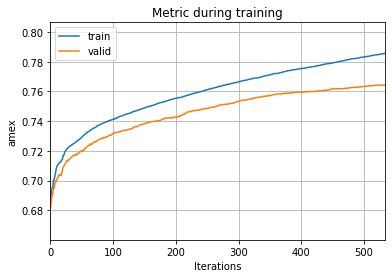

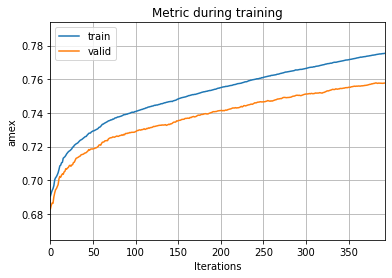

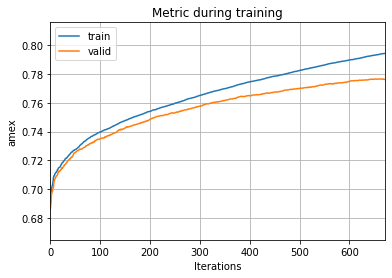

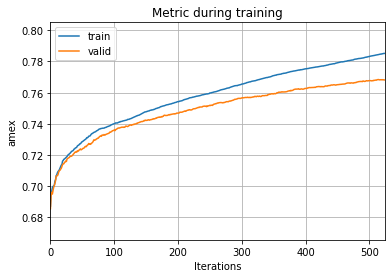

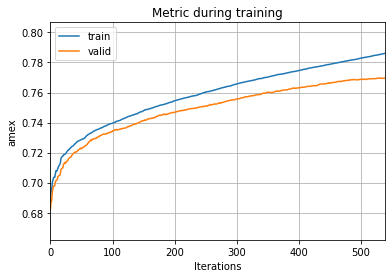

In [ ]:
lgb_params = {"learning_rate": 0.01,
              'num_leaves': 127,
              'max_bins': 511,
              'min_child_samples': 2400}

models = fit_lgbm(train[features], train[Config.target], params=lgb_params)
# models = [joblib.load(f'{EXP_MODEL}/lgbm_fold{i}.pkl') for i in range(Config.n_splits)]
pred = inference_lgbm(models, test[features])

## Plot importances

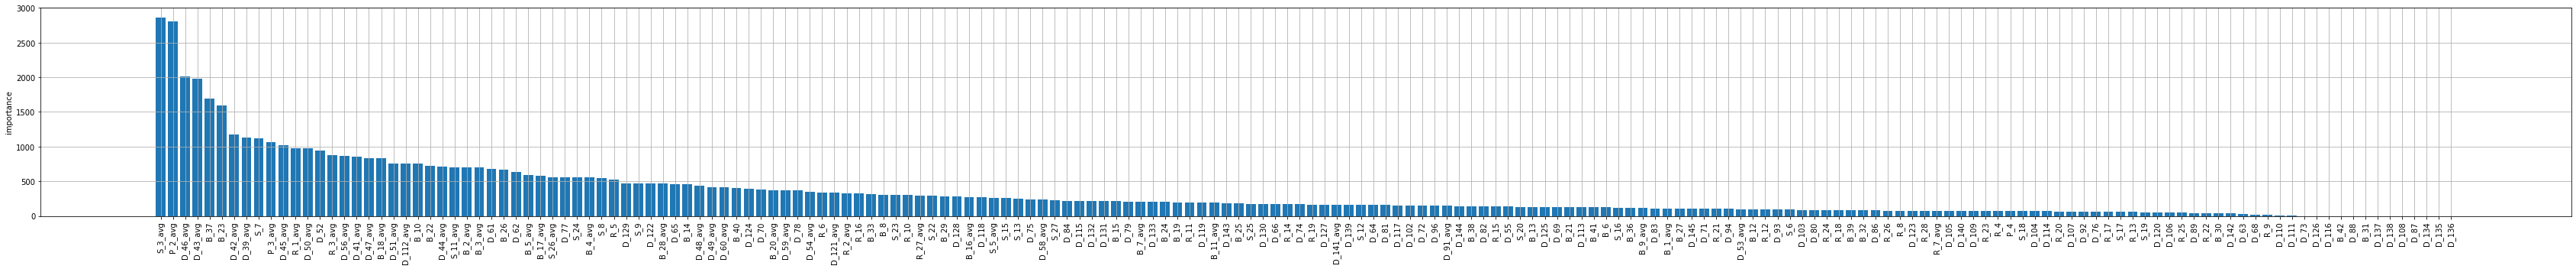

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

## Submission

In [ ]:
sub = pd.DataFrame({'customer_ID': test['customer_ID'],
                    'prediction': pred})
sub.to_csv(f'{SUBMISSION}/submission.csv', index=False)

In [ ]:
! kaggle competitions submit -c amex-default-prediction -f /content/drive/MyDrive/workspace/kaggle-amex/Submission/submission.csv -m "Take mean for some columns"

100% 75.1M/75.1M [00:10<00:00, 7.52MB/s]
Successfully submitted to American Express - Default Prediction